In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt
import math
import galois
import itertools
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [4]:
class Decoder:
    
    def __init__ (self,H, num_iter,cluster_size):
        # code parameters
        self.n = H.shape[1]
        self.k = self.n - H.shape[0]
        self.H = H
        self.num_iter = num_iter
        
        # misc parameters (epsilon : for numerical stability)
        self.ep = 1e-5
        
        # graph parameters
        self.num_VN = self.n
        self.num_CN = self.n-self.k
        self.cluster_size = cluster_size
        
        # adjacency list for VN and CN
        self.CN = []
        self.VN = []
        self.construct_graph(H)
        self.initialize_clusters(self.cluster_size)
        self.iteration_number = 0
        self.policy = None # policy for choosing clusters (using RL)
        
    # build the adjacency list for Tanner Graph
    def construct_graph(self,H):
        for i in range(self.num_CN):
            temp = []
            for j in range(self.num_VN):
                if H[i,j]==1:
                    temp.append(j)
            self.CN.append(temp)
            
        for i in range(self.num_VN):
            temp = []
            for j in range(self.num_CN):
                if H[j,i]==1:
                    temp.append(j)
            self.VN.append(temp)
    
    # print the tanner graph
    def print_graph(self,mode):
        if mode=="matrix":
            print(self.H)
        elif mode=="list":
            print('CN : ',self.CN)
            print('VN : ',self.VN)
        else:
            print('Invalid mode')
    
    
    # initialize clusters of CNs
    def initialize_clusters(self,cluster_size):
        self.num_clusters = math.ceil(self.num_CN/cluster_size)
        self.MI = np.zeros(self.num_clusters) # for storing current MI of clusters

        self.clusters = []
        for i in np.arange(0,self.num_CN,cluster_size):
            temp = []
            for j in range(i,min(i+cluster_size,self.num_CN)):
                temp.append(j)
            self.clusters.append(temp)  
            

                    
    # returns the absolute min, 2nd min and parity of the input array
    def get_min(self,arr):
        arr = np.array(arr)
        arr = arr[~np.isnan(arr)]
        parity = np.prod(np.sign(arr))
        if len(arr) < 2:
            print("arr = ",arr)
            raise ValueError("Not enough valid elements in the array.")
        arr = np.sort(np.abs(arr))
        return arr[0],arr[1],parity
    
    # perform row update of cluster a 
    def row_update(self,a):
        # subtract step (removing known beliefs)
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = self.sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(self.L[i])
            for j in range(self.num_VN):
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = p*np.sign(self.L[i,j])*m2 if np.abs(self.L[i,j])==m1 else p*np.sign(self.L[i,j])*m1

    def col_update(self,a):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] + tot
            
    def pseudo_row_update(self,a):
        # subtract step (removing known beliefs)
        p_L = self.L
        p_sum = self.sum
        
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p_sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(p_L[i])
            for j in range(self.num_VN):
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p*np.sign(p_L[i,j])*m2 if np.abs(p_L[i,j])==m1 else p*np.sign(p_L[i,j])*m1
        
        return p_L, p_sum

    def pseudo_col_update(self, a, p_L, p_sum):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] + tot
        
        return p_L


#     def decode(self,y,verbose="off",scheduling="round-robin"):
#         # sum is initialized by incoming beliefs (initial LLRs)
#         self.sum = y
        
#         # initializing the storage matrix
#         self.L = np.full(self.H.shape, np.nan, dtype=float)  # Initialize with NaNs
#         for i in range(self.num_CN):
#             for j in range(self.num_VN):
#                 self.L[i,j] = 0 if self.H[i,j]==1 else np.nan
        
# #         # initial MI approximation
# #         self.MI = self.get_MI(self.L)
        
#         for k in range(self.num_iter):
#             self.MI = self.get_MI(self.L)
#             self.iteration_number = k
#             a = self.get_next_cluster(k,scheduling)
#             if verbose=="on":
#                 print("Iteration : ",k,"\tCluster scheduled : ",a)
#             self.row_update(a)
#             self.col_update(a)
#             c_hat = np.array([1 if val<0 else 0 for val in self.sum])
#             if self.stopping_criteria(k,c_hat):
#                 break
#         return c_hat
    
    def get_MI(self,L):
        var = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            total = 0
            count = 0
            for i in self.clusters[a]:
                for j in self.CN[i]:
                    total = total + np.abs(L[i,j])
                    count = count + 1
            mean = total/count
            var[a] = mean*2
        
        MI = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            MI[a] = self.J(var[a])
        
        return MI

        
    def J(self,sigma):
        # constants
        a_J1 = -0.0421061
        b_J1 = 0.209252
        c_J1 = -0.00640081

        a_J2 = 0.00181491
        b_J2 = -0.142675
        c_J2 = -0.0822054
        d_J2 = 0.0549608

        # threshold sigma*
        sigma_star = 1.6363
        
        if 0 <= sigma <= sigma_star:
            return a_J1 * sigma**3 + b_J1 * sigma**2 + c_J1 * sigma
        elif sigma_star < sigma < 10:
            exponent = a_J2 * sigma**3 + b_J2 * sigma**2 + c_J2 * sigma + d_J2
            return 1 - math.exp(exponent)
        else:  # sigma >= 10
            return 1

            
        
    def stopping_criteria(self,k,c_hat):
        c1 = k>self.num_iter
        c2 = (np.sum(np.dot(self.H,c_hat.T)%2)==0)
        return c1 or c2
    
    # calculates the difference between information metrics for cluster a
    def calculate_residual(self, info, info_new, a):
        return info_new[a] - info[a]
    
    def get_next_cluster(self,iter_number,scheduling):
        # round robin
        if scheduling=="round-robin":
            return (iter_number%self.num_clusters)
        
        elif scheduling=="residual-llr":
            llr_gains = np.zeros(self.num_clusters)
            for a in range(self.num_clusters):
                p_L, p_sum = self.pseudo_row_update(a)
                max_diff = -100000
                for j in self.CN[a]:
                    max_diff = max(np.abs(self.L[a,j]-p_L[a,j]),max_diff)
                llr_gains[a] = max_diff
            return np.argmax(llr_gains)
                
    
        # Information Gain
        MI_gains = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            p_L, p_sum = self.pseudo_row_update(a)
            p_L = self.pseudo_col_update(a,p_L,p_sum)
            MI_new = self.get_MI(p_L)
            gain = self.calculate_residual(self.MI, MI_new, a)
            MI_gains[a] = gain
            
        a = np.argmax(MI_gains)
        return a
        
    
        

## Q-network architecture

- Input to the Neural Network : Number of states (length of the code)
- Output of the network : Number of actions (number of clusters)
- Both determined by the Decoder

In [5]:
# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Replay Buffer

In [6]:
# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, transition):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return batch

## DQN Agent Class

In [7]:
# Define the DQN agent class
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.8, epsilon_min=0.01, batch_size=64, buffer_size=1000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # parameters for Q-learning
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        
        # initializing networks and replay-buffer
        self.memory = ReplayBuffer(buffer_size)
        self.policy_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # loss for the networks
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.target_optimizer = optim.Adam(self.target_net.parameters(), lr=lr)
        self.epsilon_decay_list = []  # List to store epsilon values

    # chooses either (a)random action OR (b)policy action based on epsilon greedy exploration
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()

    # memorizes the experience into the replay buffer
    def memorize(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))


    # function to perform back-propogation using the batch sampled frim replay-buffer
    def train_agent(self, timestep):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute Q-values for the current states and selected actions
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Calculate the loss using the Huber loss function
        loss = F.smooth_l1_loss(current_q_values, target_q_values.detach())

        # Perform backward pass and update weights of the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon_decay_list.append(self.epsilon)

        # Periodically update the target network weights to the policy network weights
        if timestep % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



## Environment for the Agent 

In [8]:
def simulate_environment(dec, state, action, c, eps=1e-5):
    """
    dec - decoder instance
    state - vector of LLRs of all the VNs
    action - cluster number to be scheduled
    c - actual codeword (to be used to calculate reward)
    """
    # take action on the decoder (schedule cluster 'action') and update the state
    dec.row_update(action)
    dec.col_update(action)
    
    # find the new state 
    new_state = dec.sum
    
    # get the reward (define reward function here)
    c_hat = np.array([1 if val<0 else 0 for val in new_state])
    error = np.sum((c_hat+c)%2)/len(c)
    reward = 1/(error+eps)
    
    return new_state, reward
    
    


In [9]:
def circular_shift_identity(z, k):
    """
    Generate a z x z identity matrix with circularly shifted rows by k positions.
    If k == -1, return a z x z zero matrix.
    """
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    """
    Expand the base matrix B into the full parity check matrix with expansion factor z.

    B: Base matrix of size m x n
    z: Expansion factor

    Returns the expanded parity-check matrix of size (m*z) x (n*z).
    """
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H

def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C

# B = np.loadtxt('./base_matrices/NR_1_6_13.txt', dtype=int)
# print("Shape of B : ",B.shape)

# H = expand_base_matrix(B=B,z=13)
# print("Shape of H : ",H.shape)
# H = np.array( [[0,0,1,1,0,0,1,0,0,0,0,0,0,0,0]
# ,[1,0,0,0,1,0,0,1,0,0,0,0,0,0,0]
# ,[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0]
# ,[1,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
# ,[0,1,0,1,0,0,0,1,0,0,0,0,0,0,0]
# ,[0,0,1,0,1,0,0,0,1,0,0,0,0,0,0]
# ,[1,0,0,1,0,0,0,0,1,0,0,0,0,0,0]
# ,[0,1,0,0,1,0,1,0,0,0,0,0,0,0,0]
# ,[0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
# ,[1,0,0,1,0,0,1,0,0,1,0,0,1,0,0]
# ,[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0]
# ,[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]],dtype=int)

# n = H.shape[1]
# C = get_codewords(H)
# C = np.array(C)
# dmin = np.min(np.sum(C[1:],axis=1))


B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
            [3,1,-1,-1,0,0,1,2,3,0],
            [1,0,0,-1,1,4,2,1,0,-1],
            [-1,0,0,2,3,-1,-1,-1,0,-1],
            [1,0,2,0,1,0,-1,-1,-1,-1],
            [2,1,0,0,2,-1,-1,-1,1,-1]]
            ,dtype=int)

B = np.array([  [0, 2, -1, 3, 0, 0,-1, -1, -1, -1],
                [3, 1, -1,-1, 1, 0, 0, -1, -1, -1],
                [1, -1, 2, -1, 0,-1, 0, -1, -1, -1],
                [-1, 1, -1, 2, 3, -1,-1,  0, -1, -1],
                [2, -1, 2, 0, -1,  0,-1, -1,  0, -1],
                [1, -1, 4, 0, 2, -1, 3, -1, -1,  0]]
                ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)

print(H.shape)
# num_iter = 100
# dec = Decoder(H,"bsc",0,num_iter,3)


B = 
 [[ 0  2 -1  3  0  0 -1 -1 -1 -1]
 [ 3  1 -1 -1  1  0  0 -1 -1 -1]
 [ 1 -1  2 -1  0 -1  0 -1 -1 -1]
 [-1  1 -1  2  3 -1 -1  0 -1 -1]
 [ 2 -1  2  0 -1  0 -1 -1  0 -1]
 [ 1 -1  4  0  2 -1  3 -1 -1  0]]
H : 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  7
(30, 50)


### Generating snrdbs for episodes

In [10]:
min_snrdb = 1.5
max_snrdb = 3.5
EPISODES = 50
num_iter = 100
cluster_size = 6
num_clusters = math.ceil(H.shape[0]/cluster_size)
state_dim = num_clusters
action_dim = num_clusters
verbose = "off"

snrdb_vals = np.random.uniform(min_snrdb, max_snrdb, EPISODES)


In [11]:
average_threshold = 0.5

def MI_stopping_criteria(MI):
    # if np.sum(MI)/len(MI)>=average_threshold:
    #     return True
    
    return False

In [14]:
# Main training loop
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, lr=0.001)

print_once = True
score_list = []
const_state1 = np.array([0.1,0.03,0.5,0.15,0.06])
const_state2 = np.array([0.1,0.7,0.8,0.7,0.3])
const_state3 = np.array([0.6,0.8,0.3,0.3,0.5])

ar = []
count = 0
result1 = []
result2 = []
result3 = []

for EP in range(EPISODES):
    
    # getting a random codeword and a random snr and adding noise to it
    snrdb = snrdb_vals[EP]
    snr = math.pow(10,snrdb/20)
    c = C[np.random.choice(len(C))] # correct codeword
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    
    # creating decoder instance
    dec = Decoder(H,num_iter,cluster_size)
    
    # initializing the decoder (setting up initial state)
    dec.sum = y
    dec.L = np.full(dec.H.shape, np.nan, dtype=float)  # Initialize with NaNs
    for i in range(dec.num_CN):
        for j in range(dec.num_VN):
            dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
    dec.MI = dec.get_MI(dec.L)

    prev_MI = np.zeros(state_dim) 
    state = dec.MI-prev_MI  # initial state is the current difference in MI
    prev_MI = dec.MI
    print(f"Starting state of episode : {state}")
    score, done = 0.0, False

    timestep = 0
    while not done:
        epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon (not actually used here, can remove)
        action = agent.choose_action(state)
        if verbose=="on":
            print("===============================================================")
            print("Iteration : ",EP,timestep,"\nAction chosen : ",action)

        print("Current state = ",state,action)

        # Do one decoder iteration (s,a -> s',r)
        dec.row_update(action)
        dec.col_update(action)
        
        # get the next state
        dec.MI = dec.get_MI(dec.L)
        next_state = dec.MI - prev_MI
        prev_MI = dec.MI
        print("Next state = \t",next_state)        

        # reward
        c_hat = np.array([1 if val<0 else 0 for val in dec.sum])
        reward = (np.sum(c == c_hat)/len(c)+1e-6)
        print(f"reward collected : {reward}")

        # p_L, p_sum = dec.pseudo_row_update(action)
        # pseudo_MI = dec.get_MI(p_L)
        # reward = pseudo_MI[action]-dec.MI[action]
        # c_hat = np.array([1 if val<0 else 0 for val in dec.sum])


        if dec.stopping_criteria(timestep, c_hat) or MI_stopping_criteria(next_state):
            if timestep==num_iter+1:
                count+=1
            ar.append(count/(EP+1))
            if timestep<num_iter+1:
                reward+=(100*(0.99**timestep))
                decoding_complete = True
            done = True


        agent.memorize(state, action, reward, next_state, done)
        agent.train_agent(timestep)

        score += reward
        state = next_state

        if len(agent.memory.buffer) == agent.batch_size:
            if print_once:
                print("Training started!")
            print_once = False
        timestep = timestep + 1

    const_state_tensor1 = torch.tensor(const_state1, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor1)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result1.append(vall.copy())
    const_state_tensor2 = torch.tensor(const_state2, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor2)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result2.append(vall.copy())
    const_state_tensor3 = torch.tensor(const_state3, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor3)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result3.append(vall.copy())

    print("EP:{}, Avg_Score:{:.3f}, Total:{:.3f}, ts:{:1f}".format(EP, score/timestep, score, timestep))
    score_list.append(score/timestep)


Starting state of episode : [0. 0. 0. 0. 0.]
Current state =  [0. 0. 0. 0. 0.] 4
Next state = 	 [0.         0.         0.         0.         0.08663163]
reward collected : 1.000001
EP:0, Avg_Score:101.000, Total:101.000, ts:1.000000
Starting state of episode : [0. 0. 0. 0. 0.]
Current state =  [0. 0. 0. 0. 0.] 0
Next state = 	 [0.21041538 0.         0.         0.         0.        ]
reward collected : 0.940001
Current state =  [0.21041538 0.         0.         0.         0.        ] 0
Next state = 	 [0. 0. 0. 0. 0.]
reward collected : 0.940001
Current state =  [0. 0. 0. 0. 0.] 0
Next state = 	 [0. 0. 0. 0. 0.]
reward collected : 0.940001
Current state =  [0. 0. 0. 0. 0.] 0
Next state = 	 [0. 0. 0. 0. 0.]
reward collected : 0.940001
Current state =  [0. 0. 0. 0. 0.] 1
Next state = 	 [0.         0.36505093 0.         0.         0.        ]
reward collected : 0.960001
Current state =  [0.         0.36505093 0.         0.         0.        ] 4
Next state = 	 [0.         0.         0.      

KeyboardInterrupt: 

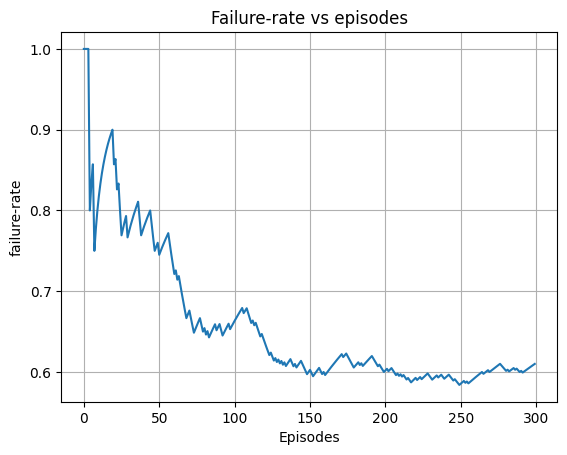

In [14]:
plt.plot(ar)
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("failure-rate")
plt.title("Failure-rate vs episodes")
plt.show()

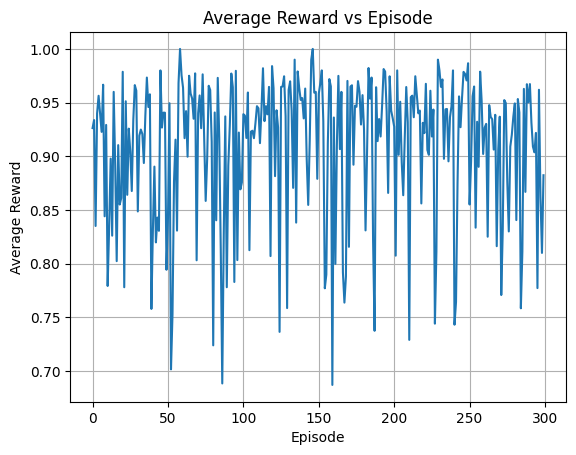

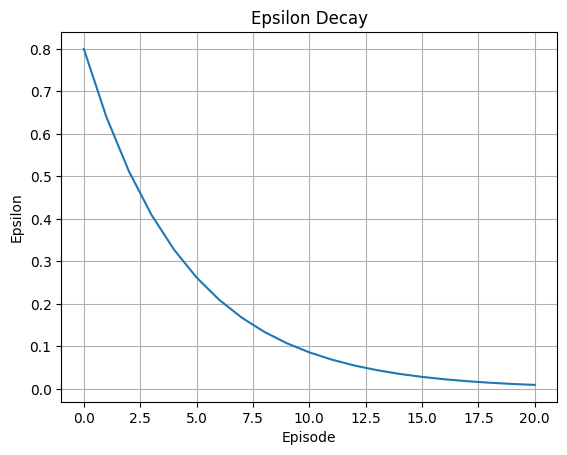

In [15]:
# Draw reward vs episode plot
import matplotlib.pyplot as plt
plt.plot(score_list)
plt.grid('on')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episode')
plt.show()

 # Draw epsilon decay plot
plt.plot(agent.epsilon_decay_list)
plt.grid('on')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.show()

In [16]:
result1 = np.array(result1)
# print(result)
# print(result.shape)
results1= np.reshape(result1,(EPISODES,num_clusters))
print(results1)

result2 = np.array(result2)
# print(result)
# print(result.shape)
results2= np.reshape(result2,(EPISODES,num_clusters))
print(results2)

result3 = np.array(result3)
# print(result)
# print(result.shape)
results3= np.reshape(result3,(EPISODES,num_clusters))
print(results3)

[[ 0.63161623  0.6067674   0.7305253   0.7632473   0.5310792 ]
 [ 1.7022091   1.5809189   1.6272473   1.6890998   1.5750175 ]
 [ 2.6265886   2.509628    2.5225966   2.5903354   2.515346  ]
 ...
 [93.858116   94.21854    94.242035   94.10553    94.17445   ]
 [93.77047    94.114296   94.05501    94.01106    93.986595  ]
 [93.70338    93.90729    93.94974    94.00725    93.91313   ]]
[[ 0.76757085  0.79605234  0.8937207   0.9100058   0.75309414]
 [ 1.9844296   1.9378052   1.9816663   1.9244946   2.021185  ]
 [ 2.9686317   2.9436667   3.0021849   2.8849535   3.0571997 ]
 ...
 [91.90858    92.333374   92.34241    91.92009    92.50613   ]
 [91.97823    92.3926     92.318146   91.98768    92.485306  ]
 [92.10613    92.385544   92.416756   92.187096   92.610214  ]]
[[ 0.8742057  0.8578635  0.9965411  1.0482682  0.7545203]
 [ 2.155274   2.0608048  2.1760514  2.116378   2.0860553]
 [ 3.2174537  3.13656    3.2491925  3.139358   3.1892056]
 ...
 [93.24055   93.21254   93.13144   93.0276    93.2926

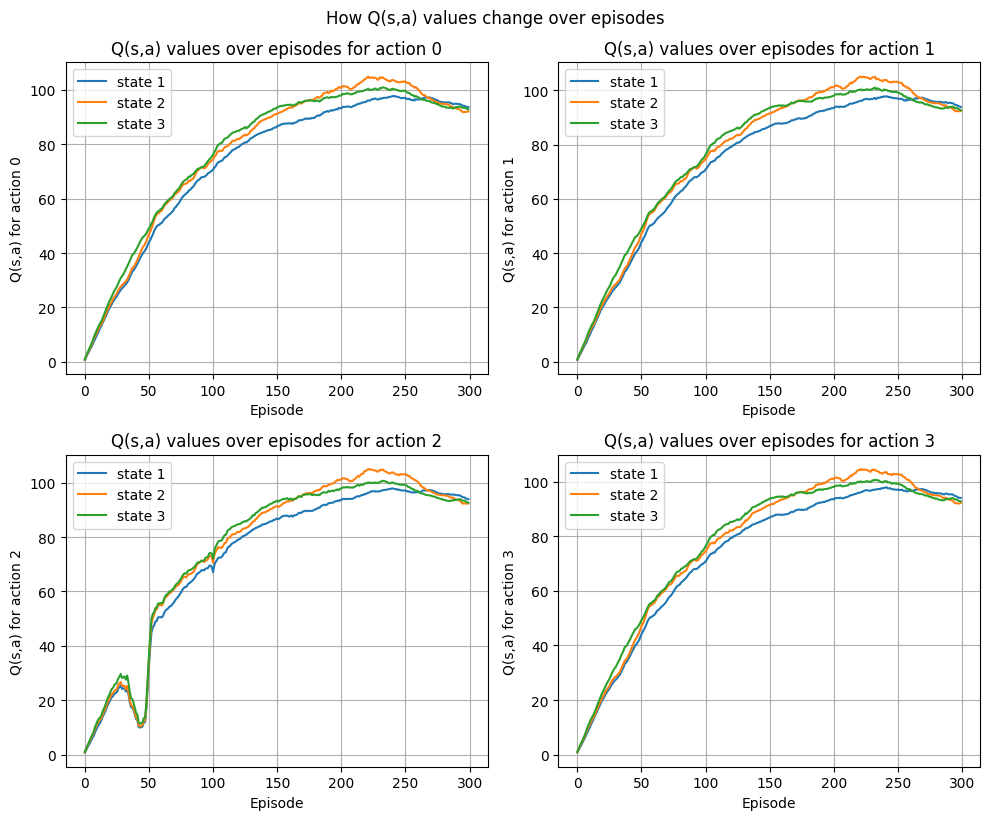

In [17]:
import matplotlib.pyplot as plt

# Assuming results1, results2, results3 are available
# and have appropriate dimensions for plotting.

A = [0, 1, 2, 3]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, a in enumerate(A):
    ax = axes[i // 2, i % 2]  # Select the appropriate subplot
    ax.plot(results1[:, a], label="state 1")
    ax.plot(results2[:, a], label="state 2")
    ax.plot(results3[:, a], label="state 3")
    ax.grid('on')
    ax.set_xlabel('Episode')
    ax.set_ylabel(f'Q(s,a) for action {a}')
    ax.legend()
    ax.set_title(f'Q(s,a) values over episodes for action {a}')

plt.tight_layout()
plt.suptitle('How Q(s,a) values change over episodes', y=1.02)
plt.show()


[0.63161623 1.7022091  2.6265886  3.5782595  4.478867  ]
[0.6067674 1.5809189 2.509628  3.4594681 4.380148 ]
[0.7305253 1.6272473 2.5225966 3.4413085 4.357605 ]
[0.7632473 1.6890998 2.5903354 3.5338604 4.4465923]
[0.5310792 1.5750175 2.515346  3.5181081 4.368737 ]

[0.76757085 1.9844296  2.9686317  4.0305123  5.0175066 ]
[0.79605234 1.9378052  2.9436667  4.0072203  5.0111723 ]
[0.8937207 1.9816663 3.0021849 4.06631   5.076517 ]
[0.9100058 1.9244946 2.8849535 3.955941  4.9521017]
[0.75309414 2.021185   3.0571997  4.1771765  5.095444  ]

[0.8742057 2.155274  3.2174537 4.3225017 5.372168 ]
[0.8578635 2.0608048 3.13656   4.238684  5.3048263]
[0.9965411 2.1760514 3.2491925 4.333317  5.403043 ]
[1.0482682 2.116378  3.139358  4.2393227 5.295703 ]
[0.7545203 2.0860553 3.1892056 4.3465633 5.3208413]



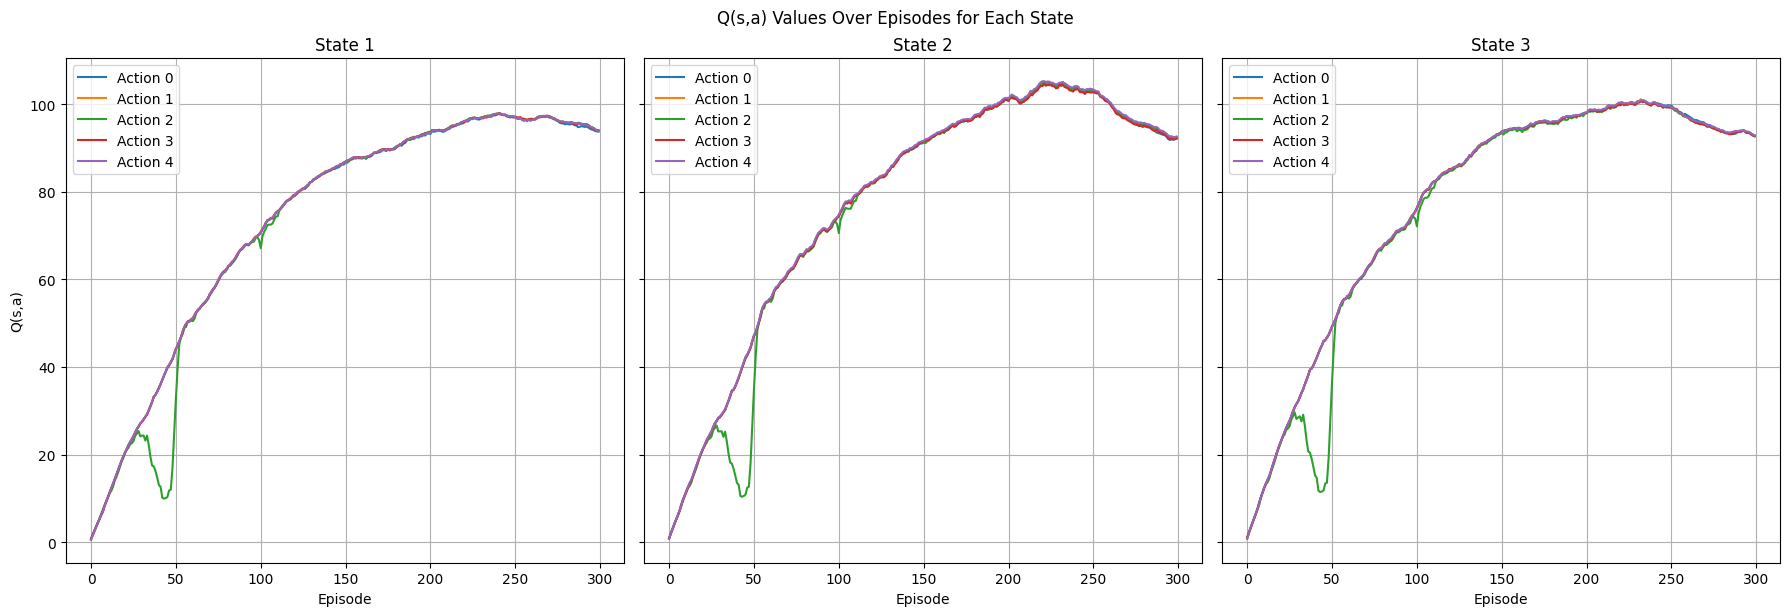

In [18]:
import matplotlib.pyplot as plt

# Assuming results1, results2, and results3 are numpy arrays with appropriate dimensions
# Each has shape (num_episodes, num_actions)

actions = [0, 1, 2, 3, 4]
states = [results1, results2, results3]
state_labels = ["State 1", "State 2", "State 3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

for i, (state, label) in enumerate(zip(states, state_labels)):
    ax = axes[i]  # Select the appropriate subplot
    for a in actions:
        ax.plot(state[:, a], label=f"Action {a}")  # Plot Q(s,a) for each action
        print(state[:, a][0:5])
    ax.grid('on')
    ax.set_xlabel('Episode')
    ax.set_title(label)
    if i == 0:
        ax.set_ylabel('Q(s,a)')
    ax.legend()
    print()

plt.tight_layout()
plt.suptitle('Q(s,a) Values Over Episodes for Each State', y=1.02)
plt.show()


### Saving the model and noting down the parameters

In [19]:
save_model(agent.policy_net, "./agents/policy_net.pth")

variables = {
    "snrdb_range": [min_snrdb,max_snrdb],
    "Number of episodes": EPISODES,
    "Max iters per episode": num_iter,
    "Cluster Size": cluster_size,
    "Learning rate":agent.lr,
    "Epsilon decay":agent.epsilon_decay,
    "Batch size":agent.batch_size,
    "Architecture\n":agent.policy_net
}

# Save variables to a text file
with open("agents/params.txt", "w") as file:
    for name, value in variables.items():
        file.write(f"{name} = {value}\n")

print("Variables saved to 'agents/params.txt'")


Model saved to ./agents/policy_net.pth
Variables saved to 'agents/params.txt'


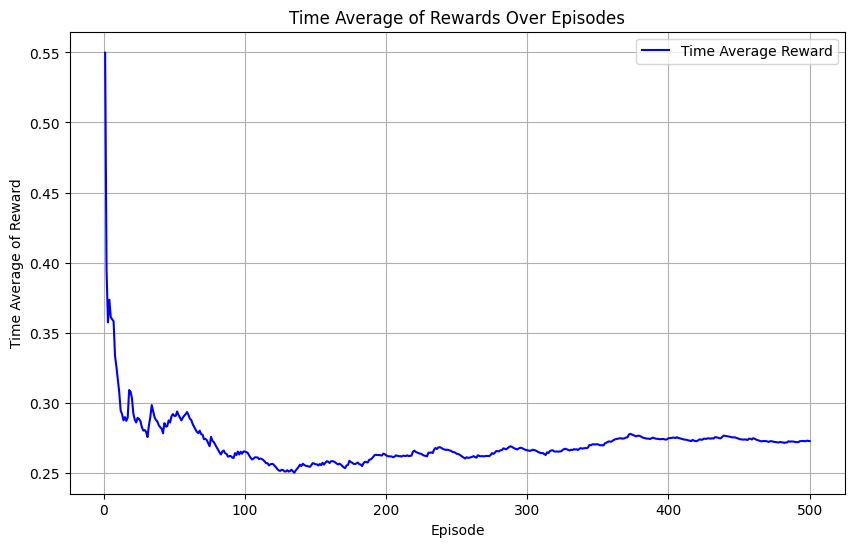

In [ ]:
time_average = np.cumsum(score_list) / np.arange(1, len(score_list)+1 )
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(score_list) + 1), time_average, label="Time Average Reward", color='b')
plt.xlabel('Episode')
plt.ylabel('Time Average of Reward')
plt.title('Time Average of Rewards Over Episodes')
plt.legend()
plt.grid()
plt.show()


EP:0, Avg_Score:0.200, Best_Score:0.200, Instant_Regret:0.000, Cumulative_Regret:0.000
EP:1, Avg_Score:0.126, Best_Score:0.200, Instant_Regret:0.074, Cumulative_Regret:0.074
EP:2, Avg_Score:0.029, Best_Score:0.200, Instant_Regret:0.172, Cumulative_Regret:0.246
EP:3, Avg_Score:0.077, Best_Score:0.200, Instant_Regret:0.124, Cumulative_Regret:0.370
EP:4, Avg_Score:0.045, Best_Score:0.200, Instant_Regret:0.155, Cumulative_Regret:0.525
EP:5, Avg_Score:0.043, Best_Score:0.200, Instant_Regret:0.158, Cumulative_Regret:0.683
EP:6, Avg_Score:0.066, Best_Score:0.200, Instant_Regret:0.134, Cumulative_Regret:0.817
EP:7, Avg_Score:0.006, Best_Score:0.200, Instant_Regret:0.195, Cumulative_Regret:1.012
EP:8, Avg_Score:0.002, Best_Score:0.200, Instant_Regret:0.199, Cumulative_Regret:1.210
EP:9, Avg_Score:0.006, Best_Score:0.200, Instant_Regret:0.194, Cumulative_Regret:1.404
EP:10, Avg_Score:0.002, Best_Score:0.200, Instant_Regret:0.198, Cumulative_Regret:1.603
EP:11, Avg_Score:0.006, Best_Score:0.200, 

EP:93, Avg_Score:0.002, Best_Score:0.284, Instant_Regret:0.281, Cumulative_Regret:18.213
EP:94, Avg_Score:0.004, Best_Score:0.284, Instant_Regret:0.279, Cumulative_Regret:18.492
EP:95, Avg_Score:0.002, Best_Score:0.284, Instant_Regret:0.282, Cumulative_Regret:18.774
EP:96, Avg_Score:0.025, Best_Score:0.284, Instant_Regret:0.258, Cumulative_Regret:19.032
EP:97, Avg_Score:0.001, Best_Score:0.284, Instant_Regret:0.283, Cumulative_Regret:19.315
EP:98, Avg_Score:0.014, Best_Score:0.284, Instant_Regret:0.270, Cumulative_Regret:19.585
EP:99, Avg_Score:0.024, Best_Score:0.284, Instant_Regret:0.260, Cumulative_Regret:19.845
EP:100, Avg_Score:0.338, Best_Score:0.338, Instant_Regret:0.000, Cumulative_Regret:19.845
EP:101, Avg_Score:0.006, Best_Score:0.338, Instant_Regret:0.332, Cumulative_Regret:20.177
EP:102, Avg_Score:0.054, Best_Score:0.338, Instant_Regret:0.283, Cumulative_Regret:20.460
EP:103, Avg_Score:0.009, Best_Score:0.338, Instant_Regret:0.329, Cumulative_Regret:20.789
EP:104, Avg_Score

EP:185, Avg_Score:0.005, Best_Score:0.405, Instant_Regret:0.400, Cumulative_Regret:46.438
EP:186, Avg_Score:0.030, Best_Score:0.405, Instant_Regret:0.375, Cumulative_Regret:46.813
EP:187, Avg_Score:0.003, Best_Score:0.405, Instant_Regret:0.403, Cumulative_Regret:47.216
EP:188, Avg_Score:0.007, Best_Score:0.405, Instant_Regret:0.398, Cumulative_Regret:47.614
EP:189, Avg_Score:0.005, Best_Score:0.405, Instant_Regret:0.400, Cumulative_Regret:48.014
EP:190, Avg_Score:0.005, Best_Score:0.405, Instant_Regret:0.400, Cumulative_Regret:48.415
EP:191, Avg_Score:0.008, Best_Score:0.405, Instant_Regret:0.398, Cumulative_Regret:48.812
EP:192, Avg_Score:0.002, Best_Score:0.405, Instant_Regret:0.403, Cumulative_Regret:49.215
EP:193, Avg_Score:0.002, Best_Score:0.405, Instant_Regret:0.404, Cumulative_Regret:49.619
EP:194, Avg_Score:0.001, Best_Score:0.405, Instant_Regret:0.404, Cumulative_Regret:50.023
EP:195, Avg_Score:0.121, Best_Score:0.405, Instant_Regret:0.285, Cumulative_Regret:50.308
EP:196, Av

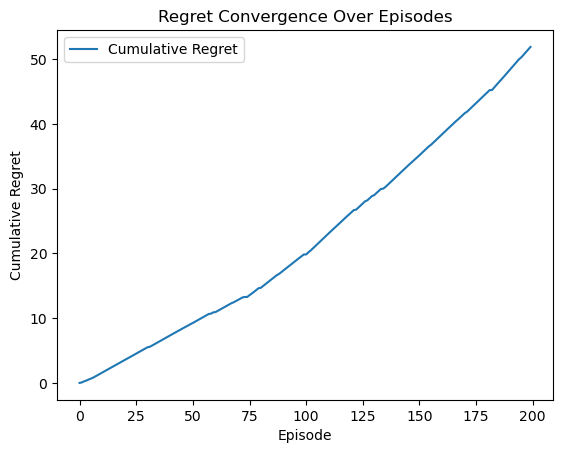

In [65]:
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# min_snrdb = 2.5
# max_snrdb = 2.5
# EPISODES = 200
# num_iter = 100
# cluster_size = 6
# num_clusters = math.ceil(H.shape[0]/cluster_size)
# state_dim = num_clusters
# action_dim = num_clusters
# verbose = "off"

# snrdb_vals = np.random.uniform(min_snrdb, max_snrdb, EPISODES)

# # Main training loop
# agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

# print_once = True
# score_list = []

# # Variables for Regret Calculation
# best_average_score = float('-inf')  # To track the best empirical baseline score
# cumulative_regret = []
# total_regret = 0  # Initialize total regret to zero

# for EP in range(EPISODES):
#     # Getting a random codeword and a random SNR and adding noise to it
#     snrdb = snrdb_vals[EP]
#     snr = math.pow(10, snrdb / 20)
#     c = C[np.random.choice(len(C))]  # Correct codeword
#     sigma = 1 / math.sqrt(snr)
#     y = np.power(-1, c) + np.random.normal(loc=0, scale=sigma, size=c.shape)  # Noisy codeword

#     # Creating decoder instance
#     dec = Decoder(H, num_iter, cluster_size)
#     dec.sum = y
#     dec.L = np.full(dec.H.shape, np.nan, dtype=float)  # Initialize with NaNs
#     for i in range(dec.num_CN):
#         for j in range(dec.num_VN):
#             dec.L[i, j] = 0 if dec.H[i, j] == 1 else np.nan
#     dec.MI = dec.get_MI(dec.L)

#     state = dec.MI  # Initial state is the current MI vals (from channel LLRs)
#     score, done = 0.0, False

#     timestep = 0
#     while not done:
#         epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon
#         action = agent.choose_action(state)
        
#         # Perform one decoder iteration (s, a -> s', r)
#         dec.row_update(action)
#         dec.col_update(action)

#         # Get the next state
#         dec.MI = dec.get_MI(dec.L)
#         next_state = dec.MI

#         # Calculate the reward
#         reward = next_state[action] - state[action]
#         c_hat = np.array([1 if val < 0 else 0 for val in dec.sum])
        
#         # Check stopping criteria
#         if dec.stopping_criteria(timestep, c_hat):
#             done = True

#         # Store transition in memory and train the agent
#         agent.memorize(state, action, reward, next_state, done)
#         agent.train_agent(timestep)

#         # Accumulate score and update state
#         score += reward
#         state = next_state
#         timestep += 1

#     # Calculate average score of the current episode
#     avg_score = score / timestep
#     score_list.append(avg_score)

#     # Update the empirical baseline if current avg_score is the highest
#     if avg_score > best_average_score:
#         best_average_score = avg_score

#     # Calculate instantaneous regret for this episode
#     instantaneous_regret = best_average_score - avg_score
#     total_regret += instantaneous_regret
#     cumulative_regret.append(total_regret)

#     print(f"EP:{EP}, Avg_Score:{avg_score:.3f}, Best_Score:{best_average_score:.3f}, "
#           f"Instant_Regret:{instantaneous_regret:.3f}, Cumulative_Regret:{total_regret:.3f}")




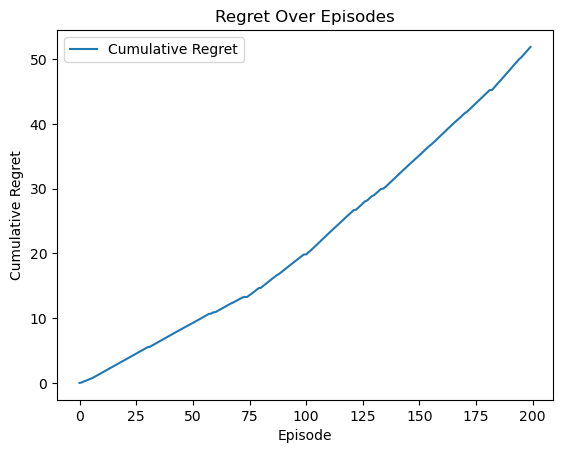

In [67]:
# Plotting Cumulative Regret
plt.plot(range(EPISODES), cumulative_regret, label='Cumulative Regret')
plt.xlabel('Episode')
plt.ylabel('Cumulative Regret')
plt.title('Regret Over Episodes')
plt.legend()
plt.show()

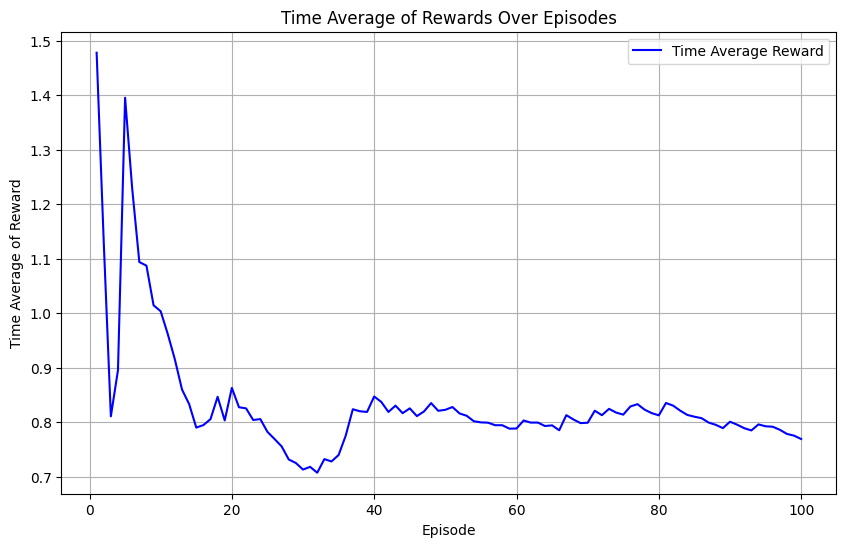

In [13]:
time_average = np.cumsum(score_list) / np.arange(1, len(score_list)+1 )
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(score_list) + 1), time_average, label="Time Average Reward", color='b')
plt.xlabel('Episode')
plt.ylabel('Time Average of Reward')
plt.title('Time Average of Rewards Over Episodes')
plt.legend()
plt.grid()
plt.show()


In [82]:
print(np.arange(1, len(score_list)))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


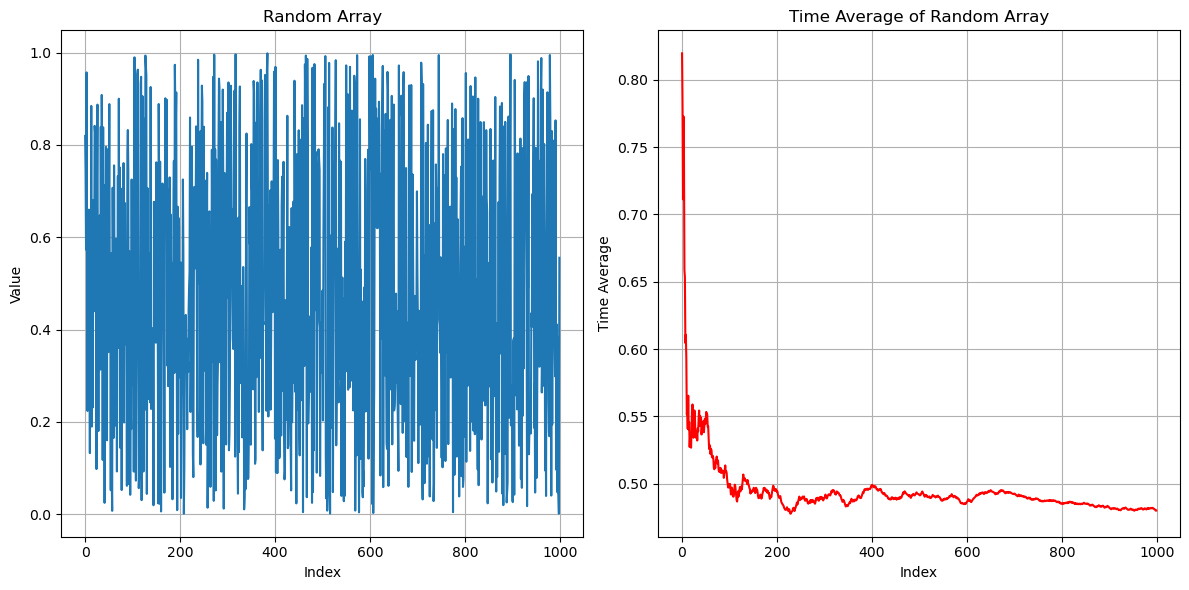

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Generate an array of N random numbers
N = 1000  # You can change the size N if needed
random_array = np.random.random(N)

# Calculate the time average of the random array
time_average = np.cumsum(random_array) / np.arange(1, N + 1)

# Plot both the random array and its time average
plt.figure(figsize=(12, 6))

# Plotting the random array
plt.subplot(1, 2, 1)
plt.plot(random_array, label='Random Array')
plt.title('Random Array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

# Plotting the time average of the random array
plt.subplot(1, 2, 2)
plt.plot(time_average, label='Time Average', color='r')
plt.title('Time Average of Random Array')
plt.xlabel('Index')
plt.ylabel('Time Average')
plt.grid(True)

plt.tight_layout()
plt.show()
